In [289]:
import pandas as pd
import numpy as np
%matplotlib inline
from scipy import stats

In [290]:
# Read Sales.Dirty.xls
salesdf = pd.read_excel('Sales.Dirty.xls')

# Lets get a sense of sample in hand
print("Rows=%d, Columns=%d" % (salesdf.shape[0], salesdf.shape[1]))
print(salesdf.dtypes)
#salesdf.head()


Rows=8399, Columns=20
Row ID                    int64
Order ID                float64
Order Date               object
Order Priority           object
Order Quantity           object
Sales                    object
Discount                float64
Ship Mode                object
Profit                  float64
Unit Price              float64
Shipping Cost           float64
Customer Name            object
Province                 object
Region                   object
Customer Segment         object
Product Category         object
Product Sub-Category     object
Product Name             object
Product Container        object
Ship Date                object
dtype: object


# Dealing with Incorrect Values

At this stage, lets try to replace incorrect values with null values.
Once this is done, we will deal with missing values in the next stage

In [291]:
# Dealing with incorrect values

# Order Date seems to have some incorrect values, lets start with that

# Lets see how many rows will be affected if we replace incorrect values with NaT
affected_date_records = pd.to_datetime(salesdf['Order Date'], errors='coerce').isnull().sum() - salesdf['Order Date'].isnull().sum()
print("Affected Order date records=%d" % affected_date_records)

# Very few rows are being affected, so safe to replace
salesdf['Order Date'] = pd.to_datetime(salesdf['Order Date'], errors='coerce') # Replace incorrect values with NaT

# Same goes for Ship Date
affected_ship_date_records = pd.to_datetime(salesdf['Ship Date'], errors='coerce').isnull().sum() - salesdf['Ship Date'].isnull().sum()
print("Affected Ship date records=%d" % affected_ship_date_records)
salesdf['Ship Date'] = pd.to_datetime(salesdf['Ship Date'], errors='coerce') # Replace incorrect values with NaT


# Order Quantity also seems to have incorrect values. Lets check how many rows will be affected if they are replaced with NaN
affected_qty_records = pd.to_numeric(salesdf['Order Quantity'], errors='coerce').isnull().sum() - salesdf['Order Quantity'].isnull().sum()
print("Affected Order Quantity records=%d" % affected_qty_records)

# safe to replace incorrect Order Quantity with NaN
salesdf['Order Quantity'] = pd.to_numeric(salesdf['Order Quantity'], downcast='integer', errors='coerce')

# Lets deal with incorrect Sales value in the same way for now
salesdf['Sales'] = pd.to_numeric(salesdf['Sales'], errors='coerce')

Affected Order date records=2
Affected Ship date records=1
Affected Order Quantity records=4


In [292]:
import re
def eliminate_numeric_values(item):
    if isinstance(item, str):
        return item if not re.match(r"^[0-9]+$", item) else pd.NaT
    else:
        return pd.NaT


# Customer Name values seems to be incorrect in some cases, they are just numbers, lets replace incorrect values with NaN
salesdf['Customer Name'] = salesdf['Customer Name'].map(eliminate_numeric_values)

        
# Product Name also seems to be incorrect in some cases, lets replace entries with NaN where its just a number
salesdf['Product Name'] = salesdf['Product Name'].map(eliminate_numeric_values)


In [293]:
salesdf.dtypes

Row ID                           int64
Order ID                       float64
Order Date              datetime64[ns]
Order Priority                  object
Order Quantity                 float64
Sales                          float64
Discount                       float64
Ship Mode                       object
Profit                         float64
Unit Price                     float64
Shipping Cost                  float64
Customer Name                   object
Province                        object
Region                          object
Customer Segment                object
Product Category                object
Product Sub-Category            object
Product Name                    object
Product Container               object
Ship Date               datetime64[ns]
dtype: object

We now have data in unified format and we can move to next step of dealing with missing values

# Dealing with Missing values and  removing unnecessary columns and rows

In [294]:
# Let check the current count of missing values in our dataset
salesdf.isnull().sum()

Row ID                    0
Order ID                545
Order Date               11
Order Priority           12
Order Quantity            4
Sales                    32
Discount                  0
Ship Mode                 4
Profit                    0
Unit Price                0
Shipping Cost             0
Customer Name            30
Province                  0
Region                   30
Customer Segment          0
Product Category         31
Product Sub-Category      0
Product Name            204
Product Container        15
Ship Date                13
dtype: int64

Deleting unnecessary rows and columns while we are dealing with missing values would certainly save us from some extra work.

In [295]:
# Order ID seems to have alot of null values, and it cannot be used as unique identifier for our records
print(salesdf['Order ID'].is_unique)

# whereas Row ID can be used as unique identifier
print(salesdf['Row ID'].is_unique)

# so there is no real significance of keeping Order ID,
# Lets drop this column
salesdf = salesdf.drop('Order ID', axis=1)

False
True


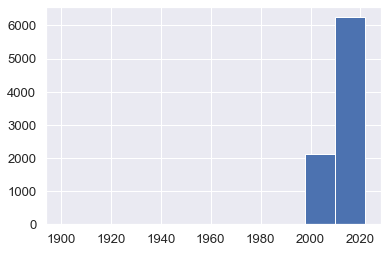

In [296]:
ship_date_year = salesdf['Ship Date'].apply(lambda x: x.year)
ship_date_year.hist()

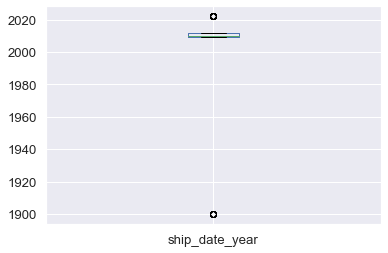

In [297]:
salesdf['ship_date_year'] = salesdf['Ship Date'].apply(lambda x: x.year)
salesdf.boxplot(column='ship_date_year', sym='o', return_type='axes')
salesdf = salesdf.drop('ship_date_year', axis=1)

In [298]:
# records with null order date and ship date in year 1900 are clearly outliers
# Lets remove such records
salesdf = salesdf[((salesdf['Ship Date'].apply(lambda x: x.year) <= 1900) & salesdf['Order Date'].isna()) == False]

# Three records where both Ship Date and Order Date are null, lets delete these rows to be on safe side
salesdf = salesdf.drop(salesdf[(salesdf['Ship Date'].isnull()) & (salesdf['Order Date'].isnull())].index)

# For remaining records missing Ship Date (there are 10 such records), lets fill them with Order Date. Its a reasonable assumption and shouldn't affect any pattern
salesdf['Ship Date'].fillna(salesdf['Order Date'], inplace=True)

In [299]:
# For Order Prioirity, we can replace null values with Not Specified
salesdf['Order Priority'].fillna('Not Specified', inplace=True)

In [300]:
salesdf['Ship Mode'].value_counts()

Regular Air       6260
Delivery Truck    1145
Express Air        979
Name: Ship Mode, dtype: int64

In [301]:
# Replace missing values in Ship Mode with 'Regular Air' i.e. most occuring value
salesdf['Ship Mode'].fillna('Regular Air', inplace=True)

In [302]:
# Handling missing Regions

# Lets first check Province value for records that are missing Region
print(salesdf[salesdf['Region'].isnull()]['Province'].value_counts())

Saskachewan    18
Quebec         12
Name: Province, dtype: int64


In [303]:
# so missing Regions belong to Saskachewan and Quebec Province

# Lets check what are the general values for Region where Province = Saskachewan
print(salesdf[salesdf['Province'] == 'Saskachewan']['Region'].value_counts())

# Lets check what are the general values for Region where Province = Quebec
print(salesdf[salesdf['Province'] == 'Quebec']['Region'].value_counts())

Prarie    895
Name: Region, dtype: int64
Quebec    768
Name: Region, dtype: int64


In [304]:
# All records with Province=Saskachewan belongs to Prarie Region and
# all records with Province=Quebec belongs to Quebec Region

# Lets fill missing values accordingly
cond = (salesdf['Province'] == 'Saskachewan') & (salesdf['Region'].isnull())
salesdf.loc[cond, 'Region'] = 'Prarie'

cond2 = (salesdf['Province'] == 'Quebec') & (salesdf['Region'].isnull())
salesdf.loc[cond2, 'Region'] = 'Quebec'

In [305]:
salesdf.isnull().sum()

Row ID                    0
Order Date                0
Order Priority            0
Order Quantity            4
Sales                    32
Discount                  0
Ship Mode                 0
Profit                    0
Unit Price                0
Shipping Cost             0
Customer Name            29
Province                  0
Region                    0
Customer Segment          0
Product Category         31
Product Sub-Category      0
Product Name            204
Product Container        15
Ship Date                 0
dtype: int64

In [306]:
# Dealing with missing Product Category
# Lets try to find all Product Sub-Categories for missing product categories
sub_cat_list = salesdf[salesdf['Product Category'].isnull()]['Product Sub-Category'].value_counts().index.to_list()
print(sub_cat_list)

def fill_missing_product_category(item):
    # Lets try to find a non null product category for same sub category in our dataframe 
    cond = (salesdf['Product Sub-Category'] == item) & (salesdf['Product Category'].isnull() == False)
    res_category = salesdf[cond].iloc[1]['Product Category']
    
    cond_to_replace = (salesdf['Product Category'].isnull() == True) & (salesdf['Product Sub-Category'] == item)
    salesdf.loc[cond_to_replace, 'Product Category'] = res_category

for item in sub_cat_list:
    fill_missing_product_category(item)
    
salesdf.isnull().sum()

['Chairs & Chairmats', 'Paper', 'Envelopes', 'Computer Peripherals', 'Binders and Binder Accessories', 'Pens & Art Supplies', 'Scissors, Rulers and Trimmers', 'Appliances', 'Office Furnishings', 'Office Machines', 'Telephones and Communication', 'Labels', 'Tables', 'Storage & Organization']


Row ID                    0
Order Date                0
Order Priority            0
Order Quantity            4
Sales                    32
Discount                  0
Ship Mode                 0
Profit                    0
Unit Price                0
Shipping Cost             0
Customer Name            29
Province                  0
Region                    0
Customer Segment          0
Product Category          0
Product Sub-Category      0
Product Name            204
Product Container        15
Ship Date                 0
dtype: int64

In [307]:
# Dealing with missing Product Container values

print(salesdf['Product Container'].value_counts())

# Lets check Product Category for these entries
salesdf[salesdf['Product Container'].isnull()]['Product Category']

Small Box     4337
Wrap Bag      1164
Small Pack     954
Jumbo Drum     622
Jumbo Box      531
Large Box      402
Medium Box     363
Name: Product Container, dtype: int64


7044    Office Supplies
7045    Office Supplies
7046         Technology
7047    Office Supplies
7048          Furniture
7049    Office Supplies
7050    Office Supplies
7051    Office Supplies
7052    Office Supplies
7053    Office Supplies
7054         Technology
7055          Furniture
7056          Furniture
7057    Office Supplies
7058    Office Supplies
Name: Product Category, dtype: object

In [308]:
# From available data we can see that Office Supplies and Technology category generally has 'Small Box' as their container
# while furniture items has 'Jumbo Box' as their container
# we can follow same trend to fill missing values
cond = ((salesdf['Product Category'] == "Office Supplies") | \
        (salesdf['Product Category'] == "Technology")) & \
        (salesdf['Product Container'].isnull() == True)
salesdf.loc[cond, 'Product Container'] = 'Small Box'

cond2 = ((salesdf['Product Category'] == "Furniture")) & \
        (salesdf['Product Container'].isnull() == True)
salesdf.loc[cond2, 'Product Container'] = 'Jumbo Box'

In [309]:
salesdf.isnull().sum()

Row ID                    0
Order Date                0
Order Priority            0
Order Quantity            4
Sales                    32
Discount                  0
Ship Mode                 0
Profit                    0
Unit Price                0
Shipping Cost             0
Customer Name            29
Province                  0
Region                    0
Customer Segment          0
Product Category          0
Product Sub-Category      0
Product Name            204
Product Container         0
Ship Date                 0
dtype: int64

In [310]:
# Dealing with product name
# lets check how many unique product names do we have in our sample, this would give an idea of whether this feature is useful or not
prodcut_name_cardinality = len(salesdf['Product Name'].value_counts().index)
print (prodcut_name_cardinality)

1234


In [311]:
# Product Name column has too much variance (too many product names), so this wouldn't go in our Machine Learning model.
# So its not worth filling missing values for this column

# Lets drop this column
salesdf = salesdf.drop('Product Name', axis=1)

In [312]:
# Same goes for Customer Name column, we are not going to pass this feature to our ML model.
# so lets drop Customer Name column as well
salesdf = salesdf.drop('Customer Name', axis=1)

salesdf.isnull().sum()

Row ID                   0
Order Date               0
Order Priority           0
Order Quantity           4
Sales                   32
Discount                 0
Ship Mode                0
Profit                   0
Unit Price               0
Shipping Cost            0
Province                 0
Region                   0
Customer Segment         0
Product Category         0
Product Sub-Category     0
Product Container        0
Ship Date                0
dtype: int64

In [313]:
# Lets calcuate % of records that are missing sales value
precent_missing = ((salesdf['Sales'].isnull().sum())/salesdf.shape[0])*100
print(precent_missing)

0.3814973772055317


In [314]:
# So only 0.38% records are missing sales value
# Lets delete these records for now
salesdf = salesdf.drop(salesdf[salesdf['Sales'].isnull()].index)

# Lets do the same for Order Quantity
salesdf = salesdf.drop(salesdf[salesdf['Order Quantity'].isnull()].index)

In [315]:
# We don't really need any unique identifier for ML, lets drop Row ID as well
salesdf = salesdf.drop('Row ID', axis=1)

salesdf.isnull().sum()

Order Date              0
Order Priority          0
Order Quantity          0
Sales                   0
Discount                0
Ship Mode               0
Profit                  0
Unit Price              0
Shipping Cost           0
Province                0
Region                  0
Customer Segment        0
Product Category        0
Product Sub-Category    0
Product Container       0
Ship Date               0
dtype: int64

# Dealing with remaining categorical columns

We have alreday removed categorical columnns with too many different values like Product Name and Customer Name after checking value_counts, Lets run same analysis over other categorical variables

High             1753
Low              1711
Not Specified    1672
Medium           1613
Critical         1603
Name: Order Priority, dtype: int64


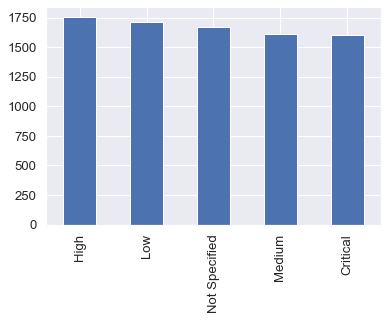

In [316]:
# For Order Priority

print(salesdf['Order Priority'].value_counts())
salesdf['Order Priority'].value_counts().plot(kind='bar')

So distribution looks uniform, and it doesn't have too many unqiue values

In [317]:
salesdf.dtypes

Order Date              datetime64[ns]
Order Priority                  object
Order Quantity                 float64
Sales                          float64
Discount                       float64
Ship Mode                       object
Profit                         float64
Unit Price                     float64
Shipping Cost                  float64
Province                        object
Region                          object
Customer Segment                object
Product Category                object
Product Sub-Category            object
Product Container               object
Ship Date               datetime64[ns]
dtype: object

Regular Air       6237
Delivery Truck    1140
Express Air        975
Name: Ship Mode, dtype: int64


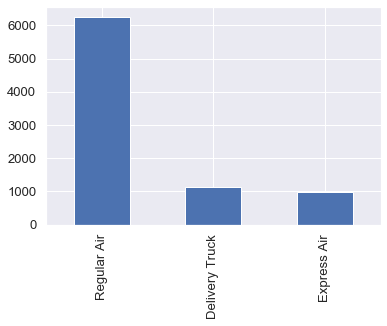

In [318]:
# For Ship Mode
print(salesdf['Ship Mode'].value_counts())
salesdf['Ship Mode'].value_counts().plot(kind='bar')

So most of the transactions in our sample (74.67% to be exact) were shipped via `Regular Air`

Ontario                  1818
British Columbia         1107
Saskachewan               912
Alberta                   865
Manitoba                  791
Quebec                    774
Yukon                     540
Nova Scotia               457
Northwest Territories     394
New Brunswick             323
Prince Edward Island      211
Newfoundland               82
Nunavut                    78
Name: Province, dtype: int64


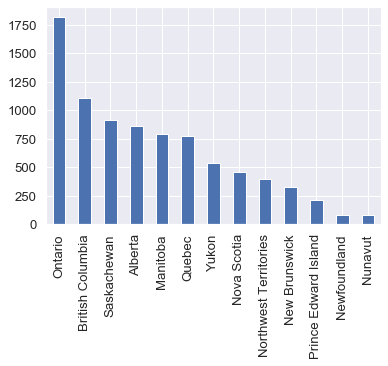

In [319]:
# For Province
print(salesdf['Province'].value_counts())
salesdf['Province'].value_counts().plot(kind='bar')

West                     1972
Ontario                  1818
Prarie                   1703
Atlantic                 1073
Quebec                    774
Yukon                     540
Northwest Territories     394
Nunavut                    78
Name: Region, dtype: int64


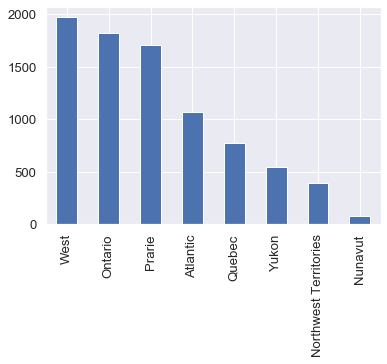

In [320]:
# For Region
print(salesdf['Region'].value_counts())
salesdf['Region'].value_counts().plot(kind='bar')

Both Province and Region are following same distribution. So we can keep Region as it has less unique values and its equally meaningful.

In [321]:
salesdf = salesdf.drop('Province', axis=1)

Corporate         3062
Home Office       2027
Consumer          1635
Small Business    1628
Name: Customer Segment, dtype: int64


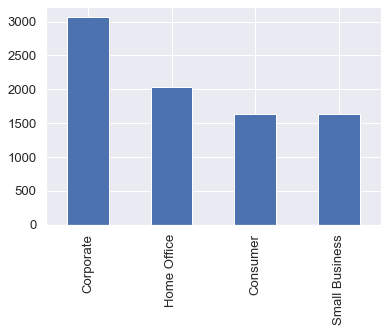

In [322]:
# For Customer Segment 
print(salesdf['Customer Segment'].value_counts())
salesdf['Customer Segment'].value_counts().plot(kind='bar')

More transactions are from Corporate customers. This is a valuable information, could be useful for other departments as well like for targeted marketing.

Office Supplies    4587
Technology         2053
Furniture          1712
Name: Product Category, dtype: int64


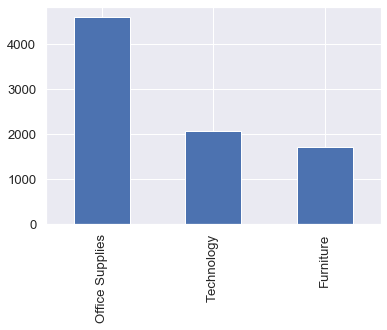

In [323]:
# For Product Category
print(salesdf['Product Category'].value_counts())
salesdf['Product Category'].value_counts().plot(kind='bar')

From the trend in above plot, Most sold category is `Office Supplies`

Paper                             1219
Binders and Binder Accessories     913
Telephones and Communication       875
Office Furnishings                 781
Computer Peripherals               757
Pens & Art Supplies                629
Storage & Organization             543
Appliances                         432
Chairs & Chairmats                 385
Tables                             358
Office Machines                    336
Labels                             287
Envelopes                          243
Bookcases                          188
Rubber Bands                       178
Scissors, Rulers and Trimmers      143
Copiers and Fax                     85
Name: Product Sub-Category, dtype: int64


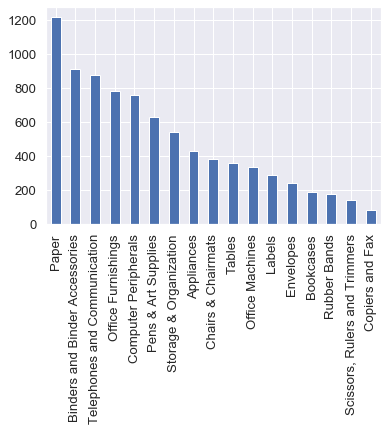

In [324]:
# For Product Sub-Category
print(salesdf['Product Sub-Category'].value_counts())
salesdf['Product Sub-Category'].value_counts().plot(kind='bar')

Small Box     4328
Wrap Bag      1160
Small Pack     951
Jumbo Drum     620
Jumbo Box      531
Large Box      400
Medium Box     362
Name: Product Container, dtype: int64


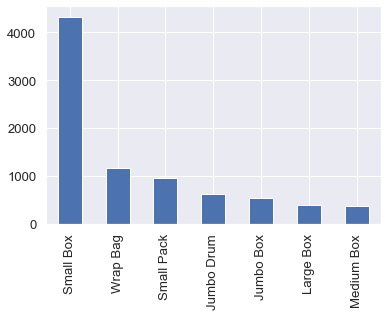

In [325]:
# For Product Container
print(salesdf['Product Container'].value_counts())
salesdf['Product Container'].value_counts().plot(kind='bar')

In [326]:
salesdf.dtypes

Order Date              datetime64[ns]
Order Priority                  object
Order Quantity                 float64
Sales                          float64
Discount                       float64
Ship Mode                       object
Profit                         float64
Unit Price                     float64
Shipping Cost                  float64
Region                          object
Customer Segment                object
Product Category                object
Product Sub-Category            object
Product Container               object
Ship Date               datetime64[ns]
dtype: object

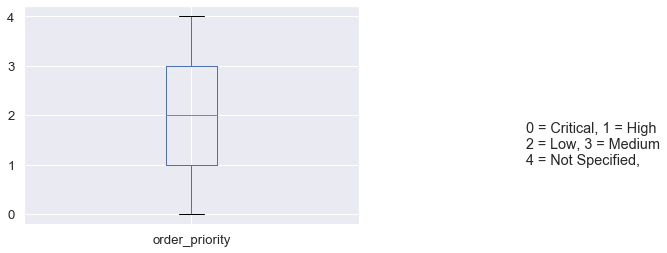

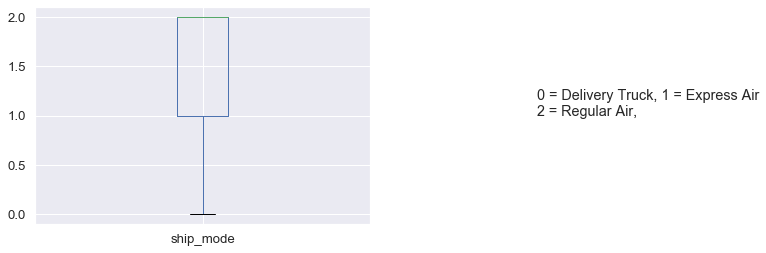

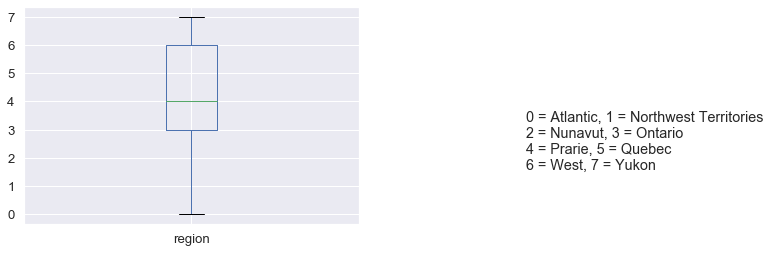

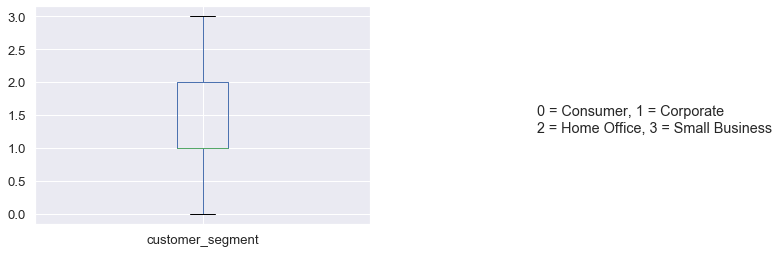

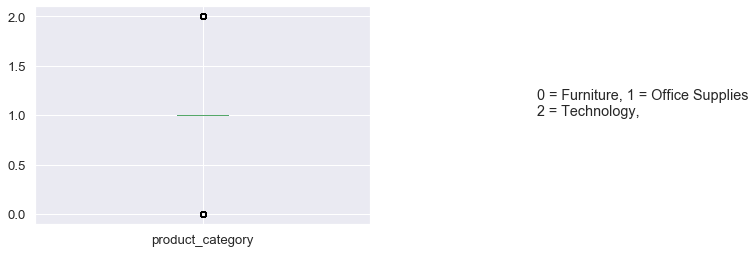

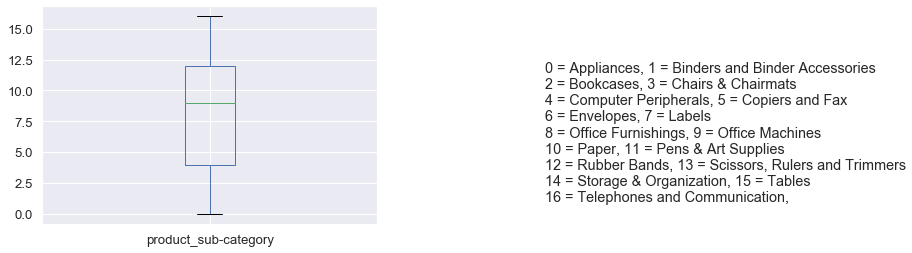

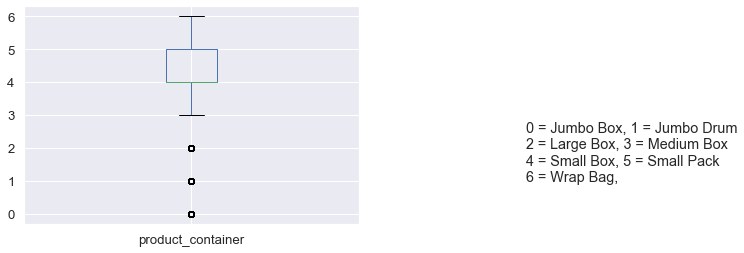

In [415]:
# For boxplots, lets first convert all columns holding categorical data to pandas category type

# Lets pick categorical columns in a separate dataframe to be on safe side
salesdf_cat = salesdf[['Order Priority', 'Ship Mode', 'Region',
                       'Customer Segment', 'Product Category', 'Product Sub-Category',
                       'Product Container']]

mapper = {}

for i in salesdf_cat.columns:
    salesdf_cat[i] = salesdf_cat[i].astype('category')
    k = i.lower().replace(' ', '_')
    # Save map to use later for better understanding
    d = dict(enumerate(salesdf_cat[i].cat.categories))
    mapper[k] = d
    salesdf_cat[k] = salesdf_cat[i].cat.codes
    salesdf_cat = salesdf_cat.drop(i, axis=1)

import matplotlib.pyplot as plt    
#print(mapper)

for i in salesdf_cat.columns:
    text_to_display = ""
    count = 0
    for k,v in mapper[i].items():
        count += 1
        text_to_display += "%s = %s"%(str(k),v)
        if count%2 == 0:
            text_to_display += "\n"
        else:
            text_to_display += ", "
    fig = plt.figure()
    plt.text(2, 1, text_to_display)
    salesdf_cat.boxplot(column=i, sym='o', return_type='axes')


# T-Test

In [327]:
# T-Test
types_map = salesdf.dtypes.to_dict()
num_columns = []
for k,v in types_map.items():
    if np.issubdtype(np.int64, v) or np.issubdtype(np.float64, v):
        num_columns.append(k)

print(num_columns)

for i in range(len(num_columns)-1):
    for j in range(i+1,len(num_columns)):
        col1 = num_columns[i]
        col2 = num_columns[j]
        t_val, p_val = stats.ttest_ind(salesdf[col1], salesdf[col2])
        print("(%s,%s) => t-value=%s, p-value=%s" % (num_columns[i], num_columns[j], str(t_val), str(p_val)))

['Order Quantity', 'Sales', 'Discount', 'Profit', 'Unit Price', 'Shipping Cost']
(Order Quantity,Sales) => t-value=-44.5389137407195, p-value=0.0
(Order Quantity,Discount) => t-value=161.12966725674866, p-value=0.0
(Order Quantity,Profit) => t-value=-11.822812178316441, p-value=3.9964633076931246e-32
(Order Quantity,Unit Price) => t-value=-19.983135255876505, p-value=8.188665624640895e-88
(Order Quantity,Shipping Cost) => t-value=51.69520445898756, p-value=0.0
(Sales,Discount) => t-value=45.190292191482314, p-value=0.0
(Sales,Profit) => t-value=38.499890530314595, p-value=0.0
(Sales,Unit Price) => t-value=42.774598711822804, p-value=0.0
(Sales,Shipping Cost) => t-value=44.86380370612504, p-value=0.0
(Discount,Profit) => t-value=-13.772921561952915, p-value=6.36602626876494e-43
(Discount,Unit Price) => t-value=-28.02843789920349, p-value=5.81737320653967e-169
(Discount,Shipping Cost) => t-value=-67.6579701418828, p-value=0.0
(Profit,Unit Price) => t-value=6.764248794815616, p-value=1.38

Conducted t-test for between all numeric columns in our dataset(i.e. `'Order Quantity', 'Sales', 'Discount', 'Profit', 'Unit Price', 'Shipping Cost'`) and as shown in the results above all p-value for every pair turns out to be less than 0.05 (p-val < 0.05), infact its very small for every pair.
Thus, there is a statistically significant difference between all above mentioned numeric columns

# 1-way Anova

In [328]:
categorical = list((set(salesdf.columns) - set(num_columns)) - set(['Order Date', 'Ship Date']))
print(categorical)
print(num_columns)

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Taking 1-way anova of Sales with all categorical variables
for i in categorical:
    model = ols('Sales ~ C(Q("%s"))'% i, data=salesdf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print ("\nAnova => Sales - %s" % i)
    display(anova_table)


['Ship Mode', 'Customer Segment', 'Order Priority', 'Product Category', 'Region', 'Product Container', 'Product Sub-Category']
['Order Quantity', 'Sales', 'Discount', 'Profit', 'Unit Price', 'Shipping Cost']

Anova => Sales - Ship Mode


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",1.757056e+10,2.0,817.976737,0.0
Residual,8.967040e+10,8349.0,NaN,NaN



Anova => Sales - Customer Segment


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",1.941470e+07,3.0,0.50386,0.679611
Residual,1.072216e+11,8348.0,NaN,NaN



Anova => Sales - Order Priority


,sum_sq,df,F,PR(>F)
"C(Q(""Order Priority""))",7.553057e+07,4.0,1.470749,0.208165
Residual,1.071654e+11,8347.0,NaN,NaN



Anova => Sales - Product Category


,sum_sq,df,F,PR(>F)
"C(Q(""Product Category""))",9.360399e+09,2.0,399.210859,2.640145e-166
Residual,9.788057e+10,8349.0,NaN,NaN



Anova => Sales - Region


,sum_sq,df,F,PR(>F)
"C(Q(""Region""))",1.008541e+08,7.0,1.122065,0.345725
Residual,1.071401e+11,8344.0,NaN,NaN



Anova => Sales - Product Container


,sum_sq,df,F,PR(>F)
"C(Q(""Product Container""))",2.503095e+10,6.0,423.4749,0.0
Residual,8.221002e+10,8345.0,NaN,NaN



Anova => Sales - Product Sub-Category


,sum_sq,df,F,PR(>F)
"C(Q(""Product Sub-Category""))",3.368875e+10,16.0,238.602344,0.0
Residual,7.355222e+10,8335.0,NaN,NaN


With our null hypothesis being Ho = no difference between population means of Sales and groups(categorical columns).
Above results of 1-way Anova indicates that for Ship Mode, Product Category, Product Container and Product Sub-Category p-value turns out to be less than 0.05, so we can reject our null hypothesis thus we can state with 95% confidence that difference between means exist for sales and groups in above mentioned columns

Lets perform the same 1-way anova test between profit and categorical colums we used above

In [329]:
for i in categorical:
    model = ols('Profit ~ C(Q("%s"))'% i, data=salesdf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print ("\n Anova => Profit - %s" % i)
    display(anova_table)



 Anova => Profit - Ship Mode


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",4.346644e+06,2.0,1.517422,0.219337
Residual,1.195783e+10,8349.0,NaN,NaN



 Anova => Profit - Customer Segment


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",2.001609e+06,3.0,0.465696,0.706225
Residual,1.196017e+10,8348.0,NaN,NaN



 Anova => Profit - Order Priority


,sum_sq,df,F,PR(>F)
"C(Q(""Order Priority""))",1.876319e+07,4.0,3.2783,0.010776
Residual,1.194341e+10,8347.0,NaN,NaN



 Anova => Profit - Product Category


,sum_sq,df,F,PR(>F)
"C(Q(""Product Category""))",1.674584e+08,2.0,59.268495,2.760790e-26
Residual,1.179471e+10,8349.0,NaN,NaN



 Anova => Profit - Region


,sum_sq,df,F,PR(>F)
"C(Q(""Region""))",8.937897e+06,7.0,0.891305,0.512174
Residual,1.195323e+10,8344.0,NaN,NaN



 Anova => Profit - Product Container


,sum_sq,df,F,PR(>F)
"C(Q(""Product Container""))",1.879439e+08,6.0,22.200914,4.454239e-26
Residual,1.177423e+10,8345.0,NaN,NaN



 Anova => Profit - Product Sub-Category


,sum_sq,df,F,PR(>F)
"C(Q(""Product Sub-Category""))",6.749833e+08,16.0,31.152498,6.169074e-93
Residual,1.128719e+10,8335.0,NaN,NaN


So, we performed 1-way Anova of Profit with Categorical columns and results indicates that for Order Priority, Product Category, Product Container and Product Sub-Category, p-value is less than 0.05, so we can state with 95% confidence that difference between means exist for profit and groups in above mentioned columns

# 2-way Anova

In [330]:
# Making a list of tuples holding 2 categorical columns
lst = []
for i in range(len(categorical)-1):
    for j in range(i+1, len(categorical)):
        lst.append((categorical[i], categorical[j]))
        
# Lets perform 2-way anova with Sales and tuples we populated in above list
for i in lst:
    model = ols('Sales ~ C(Q("%s")) + C(Q("%s")) + C(Q("%s")):C(Q("%s"))' % (i[0],i[1],i[0],i[1]), data=salesdf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    display(anova_table)

,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",1.757169e+10,2.0,817.968341,0.000000
"C(Q(""Customer Segment""))",2.054897e+07,3.0,0.637708,0.590655
"C(Q(""Ship Mode"")):C(Q(""Customer Segment""))",6.941149e+07,6.0,1.077043,0.373543
Residual,8.958044e+10,8340.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",1.754455e+10,2.0,816.692190,0.000000
"C(Q(""Order Priority""))",4.951531e+07,4.0,1.152460,0.329804
"C(Q(""Ship Mode"")):C(Q(""Order Priority""))",7.131629e+07,8.0,0.829937,0.576008
Residual,8.954957e+10,8337.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",1.246537e+10,2.0,612.622312,5.674461e-249
"C(Q(""Product Category""))",4.255206e+09,2.0,209.126136,2.403787e-89
"C(Q(""Ship Mode"")):C(Q(""Product Category""))",5.353621e+08,4.0,13.155438,1.103881e-10
Residual,8.487984e+10,8343.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",1.753639e+10,2.0,815.652661,4.940656e-324
"C(Q(""Region""))",6.668435e+07,7.0,0.886178,5.162795e-01
"C(Q(""Ship Mode"")):C(Q(""Region""))",7.844249e+07,14.0,0.521217,9.225661e-01
Residual,8.952528e+10,8328.0,NaN,NaN


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",2.676705e+08,2.0,13.618375,0.000001
"C(Q(""Product Container""))",3.669618e+02,6.0,0.000006,1.000000
"C(Q(""Ship Mode"")):C(Q(""Product Container""))",1.625037e+08,12.0,1.377961,0.240482
Residual,8.193229e+10,8337.0,NaN,NaN


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 6
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 31
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",4.472840e+07,2.0,2.584622,1.079442e-01
"C(Q(""Product Sub-Category""))",3.274423e+10,16.0,236.514891,5.824713e-280
"C(Q(""Ship Mode"")):C(Q(""Product Sub-Category""))",3.048870e+09,32.0,11.011150,9.944004e-53
Residual,7.191336e+10,8311.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",1.905104e+07,3.0,0.494566,0.686048
"C(Q(""Order Priority""))",7.516691e+07,4.0,1.463501,0.210426
"C(Q(""Customer Segment"")):C(Q(""Order Priority""))",1.613881e+08,12.0,1.047410,0.401283
Residual,1.069850e+11,8332.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",6.518851e+06,3.0,0.185264,9.064705e-01
"C(Q(""Product Category""))",9.347503e+09,2.0,398.480349,5.237274e-166
"C(Q(""Customer Segment"")):C(Q(""Product Category""))",5.470047e+07,6.0,0.777286,5.876327e-01
Residual,9.781935e+10,8340.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",2.215912e+07,3.0,0.575238,0.631249
"C(Q(""Region""))",1.035986e+08,7.0,1.152582,0.326759
"C(Q(""Customer Segment"")):C(Q(""Region""))",2.844737e+08,21.0,1.054967,0.390904
Residual,1.068335e+11,8320.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",2.075297e+07,3.0,0.703151,0.550031
"C(Q(""Product Container""))",2.503229e+10,6.0,424.071049,0.000000
"C(Q(""Customer Segment"")):C(Q(""Product Container""))",2.970266e+08,18.0,1.677306,0.035865
Residual,8.189224e+10,8324.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",7.585971e+06,3.0,0.286527,0.835168
"C(Q(""Product Sub-Category""))",3.367692e+10,16.0,238.499468,0.000000
"C(Q(""Customer Segment"")):C(Q(""Product Sub-Category""))",4.366100e+08,48.0,1.030689,0.414597
Residual,7.310802e+10,8284.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Order Priority""))",4.997352e+07,4.0,1.066138,3.714583e-01
"C(Q(""Product Category""))",9.334842e+09,2.0,398.300000,6.211985e-166
"C(Q(""Order Priority"")):C(Q(""Product Category""))",1.346649e+08,8.0,1.436474,1.755504e-01
Residual,9.769593e+10,8337.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Order Priority""))",7.819227e+07,4.0,1.523244,0.192420
"C(Q(""Region""))",1.035158e+08,7.0,1.152324,0.326916
"C(Q(""Order Priority"")):C(Q(""Region""))",3.925309e+08,28.0,1.092400,0.336099
Residual,1.066694e+11,8312.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Order Priority""))",4.805085e+07,4.0,1.222828,0.298723
"C(Q(""Product Container""))",2.500347e+10,6.0,424.202559,0.000000
"C(Q(""Order Priority"")):C(Q(""Product Container""))",4.581306e+08,24.0,1.943132,0.003782
Residual,8.170383e+10,8317.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Order Priority""))",3.035363e+07,4.0,0.863221,0.485125
"C(Q(""Product Sub-Category""))",3.364357e+10,16.0,239.195697,0.000000
"C(Q(""Order Priority"")):C(Q(""Product Sub-Category""))",8.482659e+08,64.0,1.507729,0.005598
Residual,7.267360e+10,8267.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Product Category""))",9.342344e+09,2.0,398.903180,3.648056e-166
"C(Q(""Region""))",8.279933e+07,7.0,1.010114,4.216363e-01
"C(Q(""Product Category"")):C(Q(""Region""))",2.765575e+08,14.0,1.686938,5.117085e-02
Residual,9.752121e+10,8328.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Product Category""))",4.584650e+09,2.0,278.778320,6.410913e-118
"C(Q(""Product Container""))",2.618273e+10,6.0,530.696813,0.000000e+00
"C(Q(""Product Category"")):C(Q(""Product Container""))",9.135160e+09,12.0,92.580104,8.288601e-216
Residual,6.851198e+10,8332.0,NaN,NaN


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1768: RuntimeWarning: invalid value encountered in true_divide
  F /= J
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
"C(Q(""Product Category""))",NaN,2.0,NaN,NaN
"C(Q(""Product Sub-Category""))",1.357428e+11,16.0,961.405300,0.0
"C(Q(""Product Category"")):C(Q(""Product Sub-Category""))",4.769180e+10,32.0,168.889845,0.0
Residual,7.355222e+10,8335.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Region""))",5.652056e+07,7.0,0.824284,0.566881
"C(Q(""Product Container""))",2.498662e+10,6.0,425.132795,0.000000
"C(Q(""Region"")):C(Q(""Product Container""))",8.890983e+08,42.0,2.161070,0.000021
Residual,8.126440e+10,8296.0,NaN,NaN


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 15
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 112, but rank is 111
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
"C(Q(""Region""))",3.743249e+07,7.0,0.609574,0.722908
"C(Q(""Product Sub-Category""))",3.586494e+10,16.0,255.520463,0.000000
"C(Q(""Region"")):C(Q(""Product Sub-Category""))",1.442687e+09,112.0,1.468350,0.001059
Residual,7.208382e+10,8217.0,NaN,NaN


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 8
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 96, but rank is 40
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
"C(Q(""Product Container""))",1.184988e+10,6.0,261.203151,9.283528e-212
"C(Q(""Product Sub-Category""))",5.029258e+09,16.0,41.571883,1.078108e-65
"C(Q(""Product Container"")):C(Q(""Product Sub-Category""))",7.070345e+10,96.0,97.405883,0.000000e+00
Residual,6.278726e+10,8304.0,NaN,NaN


In [331]:
# Lets perform 2-way anova with Profit and tuples we populated in above list
for i in lst:
    model = ols('Profit ~ C(Q("%s")) + C(Q("%s")) + C(Q("%s")):C(Q("%s"))' % (i[0],i[1],i[0],i[1]), data=salesdf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    display(anova_table)

,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",4.311958e+06,2.0,1.504756,0.222132
"C(Q(""Customer Segment""))",1.966922e+06,3.0,0.457601,0.711929
"C(Q(""Ship Mode"")):C(Q(""Customer Segment""))",6.502233e+06,6.0,0.756367,0.604268
Residual,1.194936e+10,8340.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",4.223861e+06,2.0,1.476941,0.228395
"C(Q(""Order Priority""))",1.864040e+07,4.0,3.258960,0.011144
"C(Q(""Ship Mode"")):C(Q(""Order Priority""))",1.781601e+07,8.0,1.557414,0.132048
Residual,1.192137e+10,8337.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",1.771898e+07,2.0,6.363215,1.732194e-03
"C(Q(""Product Category""))",1.808307e+08,2.0,64.939660,1.033561e-28
"C(Q(""Ship Mode"")):C(Q(""Product Category""))",1.610538e+08,4.0,28.918703,6.574289e-24
Residual,1.161594e+10,8343.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",4.299096e+06,2.0,1.501094,0.222947
"C(Q(""Region""))",8.890348e+06,7.0,0.886914,0.515689
"C(Q(""Ship Mode"")):C(Q(""Region""))",2.334276e+07,14.0,1.164354,0.295590
Residual,1.192559e+10,8328.0,NaN,NaN


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",3.987220e+05,2.0,1.412405e-01,0.868283
"C(Q(""Product Container""))",1.484785e+00,6.0,1.753199e-07,1.000000
"C(Q(""Ship Mode"")):C(Q(""Product Container""))",2.456086e+04,12.0,1.450045e-03,0.969625
Residual,1.176768e+10,8337.0,NaN,NaN


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 6
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 31
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
"C(Q(""Ship Mode""))",2.429534e+05,2.0,0.090254,7.638625e-01
"C(Q(""Product Sub-Category""))",1.291139e+09,16.0,59.954921,5.084002e-73
"C(Q(""Ship Mode"")):C(Q(""Product Sub-Category""))",2.147695e+08,32.0,4.986482,3.791929e-18
Residual,1.118617e+10,8311.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",2.214797e+06,3.0,0.515934,0.671294
"C(Q(""Order Priority""))",1.897638e+07,4.0,3.315389,0.010105
"C(Q(""Customer Segment"")):C(Q(""Order Priority""))",1.867522e+07,12.0,1.087591,0.365510
Residual,1.192252e+10,8332.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",1.830035e+06,3.0,0.431661,7.303302e-01
"C(Q(""Product Category""))",1.672868e+08,2.0,59.188356,2.989119e-26
"C(Q(""Customer Segment"")):C(Q(""Product Category""))",7.019832e+06,6.0,0.827904,5.480349e-01
Residual,1.178586e+10,8340.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",1.776469e+06,3.0,0.413706,0.743165
"C(Q(""Region""))",8.712758e+06,7.0,0.869586,0.529663
"C(Q(""Customer Segment"")):C(Q(""Region""))",4.264989e+07,21.0,1.418906,0.096546
Residual,1.190881e+10,8320.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",1.926706e+06,3.0,0.455049,7.137311e-01
"C(Q(""Product Container""))",1.878690e+08,6.0,22.185448,4.661823e-26
"C(Q(""Customer Segment"")):C(Q(""Product Container""))",2.419964e+07,18.0,0.952579,5.131419e-01
Residual,1.174810e+10,8324.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Customer Segment""))",1.192676e+06,3.0,0.295670,8.285601e-01
"C(Q(""Product Sub-Category""))",6.741744e+08,16.0,31.337048,1.658724e-93
"C(Q(""Customer Segment"")):C(Q(""Product Sub-Category""))",1.473020e+08,48.0,2.282303,1.167923e-06
Residual,1.113869e+10,8284.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Order Priority""))",1.743980e+07,4.0,3.092821,1.484267e-02
"C(Q(""Product Category""))",1.661350e+08,2.0,58.925654,3.873501e-26
"C(Q(""Order Priority"")):C(Q(""Product Category""))",2.460617e+07,8.0,2.181863,2.581352e-02
Residual,1.175267e+10,8337.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Order Priority""))",1.893202e+07,4.0,3.309182,0.010215
"C(Q(""Region""))",9.106733e+06,7.0,0.909595,0.497649
"C(Q(""Order Priority"")):C(Q(""Region""))",4.594217e+07,28.0,1.147195,0.270072
Residual,1.188836e+10,8312.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Order Priority""))",1.982352e+07,4.0,3.525819,7.003993e-03
"C(Q(""Product Container""))",1.890042e+08,6.0,22.410916,2.444219e-26
"C(Q(""Order Priority"")):C(Q(""Product Container""))",6.405932e+07,24.0,1.898936,5.066875e-03
Residual,1.169035e+10,8317.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Order Priority""))",1.828020e+07,4.0,3.407067,8.616933e-03
"C(Q(""Product Sub-Category""))",6.745003e+08,16.0,31.428381,8.606738e-94
"C(Q(""Order Priority"")):C(Q(""Product Sub-Category""))",1.800175e+08,64.0,2.096982,7.949497e-07
Residual,1.108889e+10,8267.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Product Category""))",1.676795e+08,2.0,59.355484,2.536512e-26
"C(Q(""Region""))",9.159035e+06,7.0,0.926323,4.845372e-01
"C(Q(""Product Category"")):C(Q(""Region""))",2.223672e+07,14.0,1.124485,3.295557e-01
Residual,1.176332e+10,8328.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Product Category""))",1.461104e+08,2.0,53.898003,5.527394e-24
"C(Q(""Product Container""))",1.689445e+08,6.0,20.773724,2.656409e-24
"C(Q(""Product Category"")):C(Q(""Product Container""))",3.348478e+08,12.0,20.586742,2.958393e-45
Residual,1.129348e+10,8332.0,NaN,NaN


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
"C(Q(""Product Category""))",NaN,2.0,NaN,NaN
"C(Q(""Product Sub-Category""))",6.053968e+08,16.0,27.940874,5.696951e-18
"C(Q(""Product Category"")):C(Q(""Product Sub-Category""))",1.604126e+09,32.0,37.017613,3.763221e-85
Residual,1.128719e+10,8335.0,NaN,NaN


,sum_sq,df,F,PR(>F)
"C(Q(""Region""))",7.987837e+06,7.0,0.810177,5.786447e-01
"C(Q(""Product Container""))",1.869938e+08,6.0,22.127124,5.518863e-26
"C(Q(""Region"")):C(Q(""Product Container""))",8.148040e+07,42.0,1.377377,5.313169e-02
Residual,1.168476e+10,8296.0,NaN,NaN


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 15
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 112, but rank is 111
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
"C(Q(""Region""))",1.030863e+07,7.0,1.114406,3.509286e-01
"C(Q(""Product Sub-Category""))",7.182075e+08,16.0,33.968039,7.335858e-96
"C(Q(""Region"")):C(Q(""Product Sub-Category""))",4.234392e+08,112.0,2.860971,3.116647e-21
Residual,1.085857e+10,8217.0,NaN,NaN


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 5
  'rank is %d' % (J, J_), ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 96, but rank is 40
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
"C(Q(""Product Container""))",7.114799e+07,6.0,8.894527,3.655631e-07
"C(Q(""Product Sub-Category""))",1.003435e+09,16.0,47.041450,4.026007e-48
"C(Q(""Product Container"")):C(Q(""Product Sub-Category""))",1.320231e+09,96.0,10.315497,1.281997e-61
Residual,1.107072e+10,8304.0,NaN,NaN


# Plotting histograms of numerical columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c5bb14be0>,
      dtype=object)

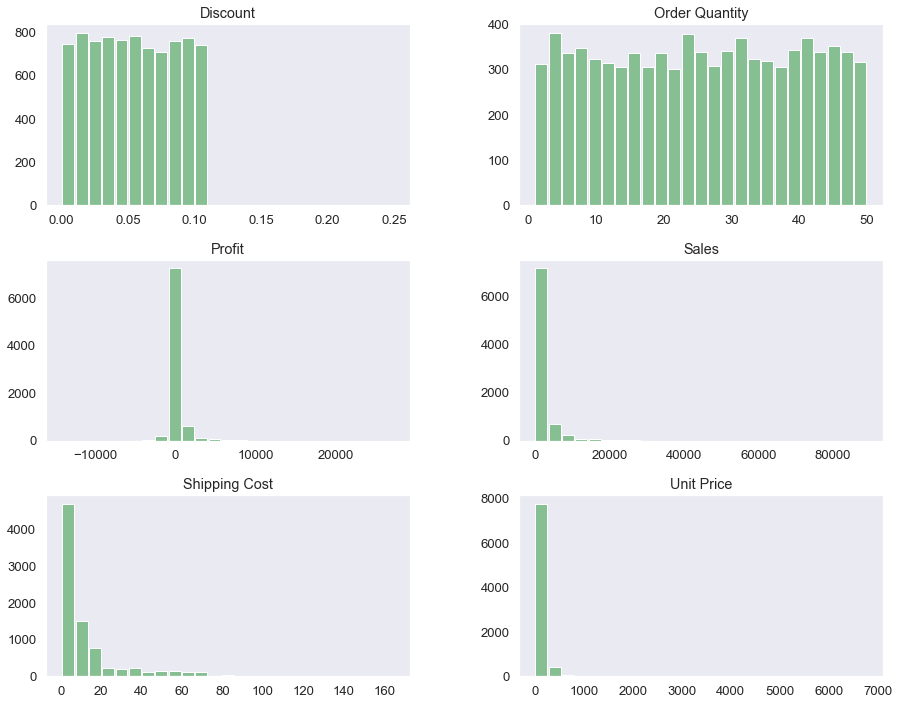

In [332]:
salesdf.hist(column=['Order Quantity', 'Sales', 'Discount', 'Profit', 'Unit Price', 'Shipping Cost'],
            bins=25, grid=False, figsize=(15,12), color='#86bf91', zorder=2, rwidth=0.9)

- So there are right skews in `Shpping Cost, Sales, Unit Price and Profit`
- No skews observed in `Order Quantity and Discount`
- Right skews in above graphs are showing that most of the data appears at the left of graph(smaller values) but there are few larger values in our sample that makes mean/average greater than median(middle value).
So the mean of Shpping Cost, Sales, Unit Price and Profit is clearly affected by outliers (i.e. few larger values) and it cannot represent data in its true essense.

In [333]:
# Lets check mean and median of all right skewed histograms
for i in ['Shipping Cost', 'Unit Price', 'Sales', 'Profit']:
    print("%s => Median=%s, Mean=%s" % (i, str(salesdf[i].median()), str(salesdf[i].mean())))

Shipping Cost => Median=6.07, Mean=12.8314511494256
Unit Price => Median=20.99, Mean=89.25710488505442
Sales => Median=448.29825, Mean=1772.038695462169
Profit => Median=-1.565, Mean=180.42065352981277


# Heat Map for numerical KPIs

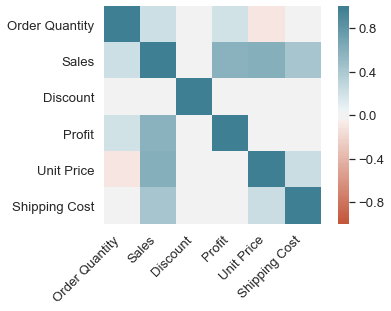

In [334]:
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)

salesnum_df = salesdf[num_columns]
corr = salesnum_df.corr()

#corr.style.background_gradient(cmap='coolwarm')

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

From above heatmap, we can draw following conclusions
- `Strong positive correlation` between `Sales and Profit`
- `Strong positive correlation` between `Sales and Unit Price`
- `Moderate positive correlation` between `Shpping Cost and Sales`
- `Weak positive correlation` between `Order Quantity and Sales`
- `Weak positive correlation` between `Order Quantity and Profit`
- `Weak negative correlation` between `Unit Price and Order Quantity`

These correlations represent the association between different features in our dataset and ML is all about correlations. This sets the base for Machine Learning modelling techinques. Correlation helps in predicting the value of an attribute (e.g. sales) from other attributes(e.g. Profit, Unit Price, Shipping Cost, Order Qunatity).

# Checking which deliveries are taking more time

In [335]:
# This is just to turn off warning
pd.set_option('mode.chained_assignment', None)

# Lets pick features of our interest and store them as a separate dataframe
salesdf_new = salesdf[['Order Date', 'Order Priority', 'Ship Mode', 'Region', 'Customer Segment', 'Product Category', 'Product Container', 'Ship Date']]

# Store difference between Ship Date and Order Date as a separate column 
salesdf_new['time_diff'] = salesdf_new['Ship Date'] - salesdf_new['Order Date']

# Sort them in descending order according to time_diff. This would bring deliveries that took more time to the top
salesdf_new = salesdf_new.sort_values(by='time_diff', ascending=False)

print("average time=" + str(salesdf_new['time_diff'].mean()))

# now lets see the stats for top 100 records in this new df
salesdf_new = salesdf_new.head(100)
print ("average time for top 100 most delayed deliveries =" + str(salesdf_new['time_diff'].mean()))

# Lets get a sense of whats common among these records
salesdf_new.sample(n=10)


average time=2 days 00:46:53.793103
average time for top 100 most delayed deliveries =12 days 03:07:12


,Order Date,Order Priority,Ship Mode,Region,Customer Segment,Product Category,Product Container,Ship Date,time_diff
5343,2011-06-16,Low,Regular Air,Prarie,Corporate,Office Supplies,Small Box,2011-06-25,9 days
3689,2010-03-30,Low,Delivery Truck,Quebec,Small Business,Furniture,Jumbo Drum,2010-04-08,9 days
4134,2011-06-06,Low,Regular Air,Ontario,Corporate,Office Supplies,Small Pack,2011-06-15,9 days
7501,2010-02-10,Low,Regular Air,West,Home Office,Office Supplies,Small Box,2010-02-19,9 days
6382,2010-12-26,Low,Regular Air,Atlantic,Home Office,Technology,Small Pack,2011-01-17,22 days
5962,2011-12-03,Low,Regular Air,Prarie,Home Office,Office Supplies,Wrap Bag,2011-12-12,9 days
6894,2010-12-26,Low,Regular Air,Yukon,Home Office,Technology,Medium Box,2011-01-19,24 days
2254,2012-09-19,Low,Express Air,Ontario,Home Office,Office Supplies,Small Box,2012-09-28,9 days
3804,2011-12-17,Low,Regular Air,Quebec,Corporate,Office Supplies,Small Box,2011-12-26,9 days
3811,2012-05-21,Low,Regular Air,Quebec,Small Business,Technology,Small Box,2012-05-30,9 days


It seems that most of these records are the orders placed with `Low` Order Priority.
Lets validate this theory

In [336]:
# Find % of records with Low Order Priority in full dataset
percent_low = ((salesdf[salesdf['Order Priority'] == "Low"].shape[0])/salesdf.shape[0])*100

# Now lets find % of records with Low Order Priority in top 100 most delayed deliveries
percent_low_delayed = ((salesdf_new[salesdf_new['Order Priority'] == "Low"].shape[0])/salesdf_new.shape[0])*100

print("percentage of records with Low Order Priority in full dataset = %s" % str(percent_low))
print("percentage of records with Low Order Priority in top 100 most delayed deliveries = %s" % str(percent_low_delayed))

percentage of records with Low Order Priority in full dataset = 20.48611111111111
percentage of records with Low Order Priority in top 100 most delayed deliveries = 90.0


So we can clearly see that % of records with Low Order Priority in top 100 most delayed deliveries is actually much higher than its percentage in full dataset. So we can conclude that records with `Low` Order Priority are taking more time in comparison with others